## Handle raw dataset

This notebook preprocesses raw netcdf data into a structure that can then be used for creating semantic segmentation datasets. Specifically, the preprocessing pipeline includes (i) loading the *fire* feature for each daily netcdf and handling them as masks, (ii) reshaping them into tiles of given size, (iii) identifying the percentage of *non-nan* and *fire* pixels in the masks for applying filters on them later, (iv) saving a csv with the *coordinates*, *date*, *year*, *non-nan*- and *fire*-percentages of all *non-nan* tiles to disk.

Then, it loads and normalizes the tile arrays and finally saves them, as well as the corresponding masks, to disk as numpy arrays.
***

Import packages

In [1]:
import pathlib
import json
from typing import Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from tqdm import tqdm

Visualize tile size granularity on map

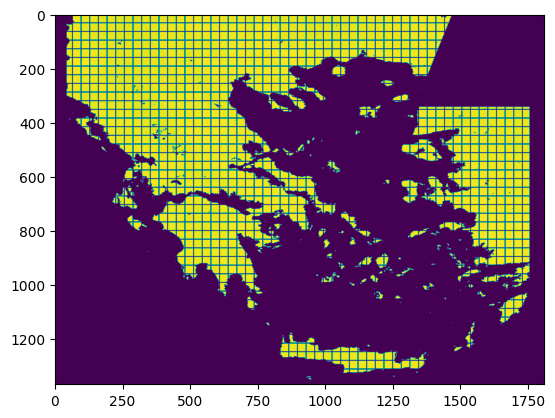

In [2]:
def add_grid_to_image(img, tile_size, line_width=3):
    h, w = img.shape[:2]
    for i in range(0, h, tile_size):
        img[i-line_width//2:i+line_width//2+1, :] = 0 # horizontal line
    for j in range(0, w, tile_size):
        img[:, j-line_width//2:j+line_width//2+1] = 0 # vertical line
    return img

netcdf_path = list(pathlib.Path(
    "/media/toshiba-hdd/mlfires/dataset/images/final_dataset/").rglob(
    '*.nc'))[100]
with xr.open_dataset(netcdf_path) as ds:
    img = np.nan_to_num(ds[["mean_temp"]].to_array().squeeze().data)

grid_img = add_grid_to_image(img, 32)
plt.imshow(grid_img)
plt.savefig("territory_tiles.png", bbox_inches="tight")
plt.show()

The `RawDataPreprocessor` class handles the data preprocessing pipeline.

In [3]:
class RawDataPreprocessor:
    def __init__(self, filepaths: List[pathlib.Path], tile_size: int = 32
                ) -> None:
        self.filepaths = filepaths
        self.tile_size = tile_size

    def extract_tiles(self, arr: np.ndarray) -> np.ndarray:
        h, w = arr.shape
        tiles_h = h // self.tile_size + (1 if h % self.tile_size else 0)
        tiles_w = w // self.tile_size + (1 if w % self.tile_size else 0)
        arr_padded = np.pad(
            arr, ((0, self.tile_size - h % self.tile_size), (
                0, self.tile_size - w % self.tile_size)), mode="constant",
            constant_values=(np.nan,),)
        arr_reshaped = arr_padded.reshape(
            tiles_h, self.tile_size, tiles_w, self.tile_size
        ).transpose(0, 2, 1, 3)

        return arr_reshaped

    def process_netcdf(self, path: pathlib.Path) -> Tuple:
        try:
            with xr.open_dataset(path) as ds:
                arr = ds[["fire"]].to_array().squeeze().data

            tiles = self.extract_tiles(arr)
            non_nan_pcts = np.mean(~np.isnan(tiles), axis=(2, 3)).flatten()
            fire_pcts = np.mean(tiles == 1.0, axis=(2, 3)).flatten()
            coords = [(i, j) for i in range(tiles.shape[0]) for j in range(
                tiles.shape[1])]
            return coords, non_nan_pcts, fire_pcts
        except ValueError:
            return None, None, None

    def run(self) -> pd.DataFrame:
        records = []
        for path in tqdm(self.filepaths):
            coords, non_nan_pcts, fire_pcts = self.process_netcdf(path)
            if coords:
                records.append({"filepath": path, "coords": coords,
                                "non_nan_pct": non_nan_pcts, "fire_pct":
                                fire_pcts})

        return pd.DataFrame(records).explode([
            "coords", "non_nan_pct", "fire_pct"], ignore_index=True)

Check number of available netcdf files in dataset

In [4]:
input_dir = "../../mlfires/dataset/images/final_dataset"
filepaths = list(pathlib.Path(input_dir).resolve().glob("*.nc"))

len(filepaths)

2524

Setting up a configuration and running it

In [5]:
params = {"filepaths": filepaths, "tile_size": 32}

preprocessor = RawDataPreprocessor(**params)
dataset = preprocessor.run()

100%|██████████| 2524/2524 [08:28<00:00,  4.96it/s]


Keep only tiles with at least 1px of *non-nan* values

In [6]:
dataset = dataset[dataset["non_nan_pct"] > 0.0].reset_index(drop=True)

Add *date* and *year* columns of each tile for using later

In [7]:
dataset["date"] = dataset["filepath"].apply(lambda x: str(
    x.stem.split("_")[0]))
dataset["year"] = dataset["date"].apply(lambda x: str(x[:4]))

Show how the dataframe looks like

In [8]:
dataset

,filepath,coords,non_nan_pct,fire_pct,date,year
0,/media/toshiba-hdd/mlfires/dataset/images/fina...,"(0, 2)",0.923828,0.0,20170706,2017
1,/media/toshiba-hdd/mlfires/dataset/images/fina...,"(0, 3)",1.0,0.0,20170706,2017
2,/media/toshiba-hdd/mlfires/dataset/images/fina...,"(0, 4)",1.0,0.0,20170706,2017
3,/media/toshiba-hdd/mlfires/dataset/images/fina...,"(0, 5)",0.969727,0.0,20170706,2017
4,/media/toshiba-hdd/mlfires/dataset/images/fina...,"(0, 6)",1.0,0.0,20170706,2017
...,...,...,...,...,...,...
3242050,/media/toshiba-hdd/mlfires/dataset/images/fina...,"(41, 37)",0.071289,0.0,20180420,2018
3242051,/media/toshiba-hdd/mlfires/dataset/images/fina...,"(41, 38)",0.02832,0.0,20180420,2018
3242052,/media/toshiba-hdd/mlfires/dataset/images/fina...,"(41, 39)",0.023438,0.0,20180420,2018
3242053,/media/toshiba-hdd/mlfires/dataset/images/fina...,"(41, 41)",0.029297,0.0,20180420,2018


Saving dataframe as csv file to disk

In [9]:
fname = f"final_dataset_alltiles_ts{params['tile_size']}.csv"
dataset.to_csv(fname, index=False)

Load utility files: (i) netcdf files containing the static features and (ii) json file for data normalization

In [10]:
dir_path = pathlib.Path("/media/toshiba-hdd/mlfires/dataset/images")

static_bef15 = xr.open_dataset(pathlib.Path(dir_path, "static",
                                            "static_bef_15.nc"))
static_aft15 = xr.open_dataset(pathlib.Path(dir_path, "static",
                                            "static_aft_15.nc"))

with open(pathlib.Path(dir_path, "norm_values_ref.json"), "r") as file:
    norm_data = json.load(file)

Normalize, handle OHE and finally save the actual tiles arrays (images and masks) to disk

In [11]:
input_dir = "../../mlfires/dataset/images/final_dataset"
output_dir = pathlib.Path(pathlib.Path(input_dir).resolve().parent,
                          f"final_dataset_alltiles_ts{params['tile_size']}")

# Used for one-hot encoded features
categorical_vars = {
    "dom_dir": [1, 2, 3, 4, 5, 6, 7, 8],
    "dir_max": [1, 2, 3, 4, 5, 6, 7, 8],
    "weekday": [1, 2, 3, 4, 5, 6, 7],
    "month": [3, 4, 5, 6, 7, 8, 9, 10],
}

features = [
    'dom_vel','res_max','max_dew_temp', 'min_dew_temp', 'mean_dew_temp',
    'max_temp', 'min_temp', 'mean_temp', 'rain_7_days', 'ndvi', 'evi',
    'lst_day','lst_night','pop', 'slope', 'road_dens', 'dem', 'curvature',
    'aspect', 'f81', 'frequency','corine_gr1', 'corine_gr4', 'corine_gr5',
    'corine_gr21', 'corine_gr22', 'corine_gr23','corine_gr24', 'corine_gr31',
    'corine_gr32', 'corine_gr33','dom_dir_1', 'dom_dir_2', 'dom_dir_3',
    'dom_dir_4', 'dom_dir_5', 'dom_dir_6', 'dom_dir_7', 'dom_dir_8',
    'dir_max_1', 'dir_max_2', 'dir_max_3', 'dir_max_4', 'dir_max_5',
    'dir_max_6', 'dir_max_7', 'dir_max_8', 'weekday_1', 'weekday_2',
    'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7',
    'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
    'month_9', 'month_10'
]


def normalize_dataset(ds: xr.Dataset) -> xr.Dataset:
    for key in norm_data.keys():
        ds[key] = (ds[key] - norm_data[key]["min"]) / (
            norm_data[key]["max"] - norm_data[key]["min"]
        )
    return ds


def ohe(ds: xr.Dataset) -> xr.Dataset:
    for key, value in categorical_vars.items():
        categorical_variable = key
        for cat_value in categorical_vars[key]:
            ds[f"{categorical_variable}_{cat_value}"] = xr.zeros_like(
                ds[categorical_variable]
            )
            ds[f"{categorical_variable}_{cat_value}"] = (
                ds[categorical_variable] == cat_value
            )
            ds[f"{categorical_variable}_{cat_value}"] = (
                ds[f"{categorical_variable}_{cat_value}"] * 1
            )
            ds[f"{categorical_variable}_{cat_value}"] = ds[
                f"{categorical_variable}_{cat_value}"
            ].where(~np.isnan(ds.lst_day.values), np.nan)

    return ds


def extract_tiles(img: np.ndarray, mask: np.ndarray, tile_size: int
                 ) -> Tuple[np.ndarray, np.ndarray]:
    h, w, c = img.shape
    tiles_h = h // tile_size + (1 if h % tile_size else 0)
    tiles_w = w // tile_size + (1 if w % tile_size else 0)
    img_padded = np.pad(img, ((0, tile_size - h % tile_size), (
        0, tile_size - w % tile_size), (0, 0)), mode="constant",
                        constant_values=(-1,),)
    img_reshaped = img_padded.reshape(
        tiles_h, tile_size, tiles_w, tile_size, c).transpose(0, 2, 1, 3, 4)
    mask_padded = np.pad(mask, ((0, tile_size - h % tile_size), (
        0, tile_size - w % tile_size)), mode="constant",
                         constant_values=(0,),)
    mask_reshaped = mask_padded.reshape(
        tiles_h, tile_size, tiles_w, tile_size).transpose(0, 2, 1, 3)

    return img_reshaped, mask_reshaped


if not output_dir.is_dir():
    pathlib.Path(output_dir, "img").mkdir(parents=True)
    pathlib.Path(output_dir, "mask").mkdir()

    last_filepath = None

    for filepath, coords, year in tqdm(zip(
        dataset["filepath"], dataset["coords"], dataset["year"]),
                                       total=len(dataset["filepath"])):
#         coords = literal_eval(coords)

        if filepath != last_filepath:
            with xr.open_dataset(filepath) as dynamic_ds:
                full_ds = (
                    xr.merge([dynamic_ds, static_bef15])
                    if int(year) < 2015 else xr.merge([dynamic_ds, static_aft15])
                )
            full_norm_ds = normalize_dataset(full_ds)
            final_ds = ohe(full_norm_ds)

            img = np.moveaxis(
                final_ds[features].to_array().squeeze().data, 0, 2)
            mask = final_ds[["fire"]].to_array().squeeze().data

            img = np.nan_to_num(img, nan=-1)
            mask = np.where(
                np.isnan(mask),
                0,
                np.where(mask == 0, 1, np.where(mask == 1, 2, mask)),
            )
            img_reshaped, mask_reshaped = extract_tiles(img, mask,
                                                        params['tile_size'])

        for dir_, arr in zip(
            ["img", "mask"], [img_reshaped, mask_reshaped]):
            path = pathlib.Path(output_dir, dir_,
                                f"{pathlib.Path(filepath).stem}_{coords[0]}_{coords[1]}")
            np.save(path, arr[coords])

        last_filepath = filepath

    print(f"Dataset directory {output_dir} created.")
else:
    print(f"Dataset directory {output_dir} already exists.")

100%|██████████| 3242055/3242055 [6:28:52<00:00, 138.95it/s]  

Dataset directory /media/toshiba-hdd/mlfires/dataset/images/final_dataset_alltiles_ts32 created.
